# Securing the Internet of Things: Comparing Classification Methods for Adversarial Network Activity Detection

## By Kimberley Maldonado

In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from scipy.stats import shapiro, kurtosis, skew
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import Counter
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.utils import resample

# Data Preprocessing

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
rt_iot2022 = fetch_ucirepo(id=942) 
  
# data (as pandas dataframes) 
X = rt_iot2022.data.features 
y = rt_iot2022.data.targets 
  
# metadata 
print(rt_iot2022.metadata) 
  
# variable information 
print(rt_iot2022.variables) 

{'uci_id': 942, 'name': 'RT-IoT2022 ', 'repository_url': 'https://archive.ics.uci.edu/dataset/942/rt-iot2022', 'data_url': 'https://archive.ics.uci.edu/static/public/942/data.csv', 'abstract': 'The RT-IoT2022, a proprietary dataset derived from a real-time IoT infrastructure, is introduced as a comprehensive resource integrating a diverse range of IoT devices and sophisticated network attack methodologies. This dataset encompasses both normal and adversarial network behaviours, providing a general representation of real-world scenarios.\nIncorporating data from IoT devices such as ThingSpeak-LED, Wipro-Bulb, and MQTT-Temp, as well as simulated attack scenarios involving Brute-Force SSH attacks, DDoS attacks using Hping and Slowloris, and Nmap patterns, RT-IoT2022 offers a detailed perspective on the complex nature of network traffic. The bidirectional attributes of network traffic are meticulously captured using the Zeek network monitoring tool and the Flowmeter plugin. Researchers can

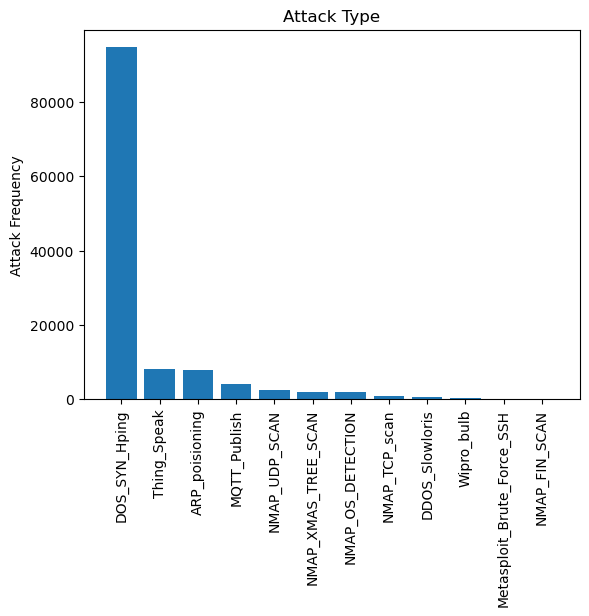

[94659  8108  7750  4146  2590  2010  2000  1002   534   253    37    28]


In [3]:
## Plotting distribution of classes
fig, ax = plt.subplots()

fruits = ['DOS_SYN_Hping', 'Thing_Speak', 'ARP_poisioning', 'MQTT_Publish', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN',
         'NMAP_OS_DETECTION', 'NMAP_TCP_scan', 'DDOS_Slowloris', 'Wipro_bulb', 'Metasploit_Brute_Force_SSH',
          'NMAP_FIN_SCAN']
counts = np.asarray(y.value_counts().tolist())
bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(fruits,counts) #, label=bar_labels, color=bar_colors)

ax.set_ylabel('Attack Frequency')
ax.set_title('Attack Type')
plt.xticks(rotation=90)
plt.show()

print(counts)

In [4]:
print(y['Attack_type'].unique())
print(X['proto'].unique())

['MQTT_Publish' 'Thing_Speak' 'Wipro_bulb' 'ARP_poisioning'
 'DDOS_Slowloris' 'DOS_SYN_Hping' 'Metasploit_Brute_Force_SSH'
 'NMAP_FIN_SCAN' 'NMAP_OS_DETECTION' 'NMAP_TCP_scan' 'NMAP_UDP_SCAN'
 'NMAP_XMAS_TREE_SCAN']
['tcp' 'udp' 'icmp']


### Resampling Majority Class

There is a significant class imbalance in the data, with a difference of 86,551 instances between DOS_SYN_Hping and the next most frequently occuring class, Thing_Speak. To mitigate this issue, the DOS_SYN_Hping class is undersampled to match the frequency of Thing_Speak, ensuring more balanced training data for model development. 

In [5]:
# Combine features and targets into a single DataFrame for processing
X = X.copy()
X['Attack_type'] = y

# Separate the majority and minority classes
df_majority = X[X['Attack_type'] == 'DOS_SYN_Hping']
df_minority = X[X['Attack_type'] != 'DOS_SYN_Hping']

# Undersample the majority class
df_majority_undersampled = resample(df_majority,
                                    replace=False,
                                    n_samples=8108,
                                    random_state=123)

# Combine the undersampled majority class with the original minority classes
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

In [6]:
print(y['Attack_type'].unique())
print(X['proto'].unique())

['MQTT_Publish' 'Thing_Speak' 'Wipro_bulb' 'ARP_poisioning'
 'DDOS_Slowloris' 'DOS_SYN_Hping' 'Metasploit_Brute_Force_SSH'
 'NMAP_FIN_SCAN' 'NMAP_OS_DETECTION' 'NMAP_TCP_scan' 'NMAP_UDP_SCAN'
 'NMAP_XMAS_TREE_SCAN']
['tcp' 'udp' 'icmp']


In [7]:
print(df_undersampled)

        id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
24112        6162         21   tcp       -       0.000004             1   
42026       24078         21   tcp       -       0.000001             1   
89966       18751         21   tcp       -       0.000004             1   
94771       38760         21   tcp       -       0.000001             1   
92343       29645         21   tcp       -       0.000001             1   
...           ...        ...   ...     ...            ...           ...   
123112      59247      63331   tcp       -       0.000006             1   
123113      59247      64623   tcp       -       0.000007             1   
123114      59247      64680   tcp       -       0.000006             1   
123115      59247      65000   tcp       -       0.000006             1   
123116      59247      65129   tcp       -       0.000006             1   

        bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
24112              

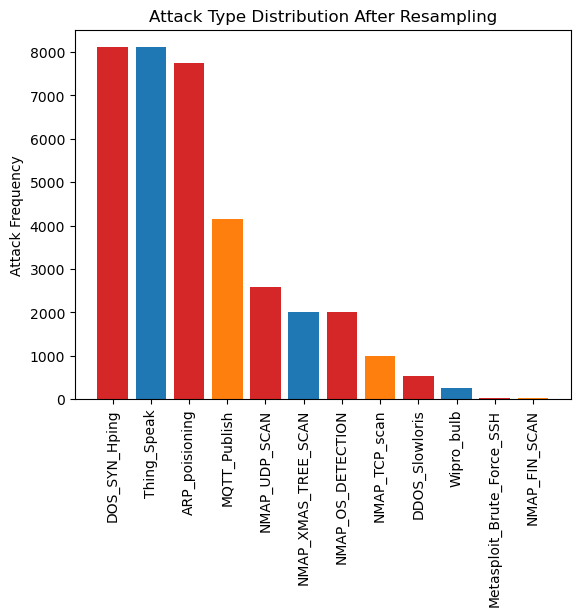

In [8]:
# Define the attack types we are interested in
fruits = ['DOS_SYN_Hping', 'Thing_Speak', 'ARP_poisioning', 'MQTT_Publish', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN',
          'NMAP_OS_DETECTION', 'NMAP_TCP_scan', 'DDOS_Slowloris', 'Wipro_bulb', 'Metasploit_Brute_Force_SSH',
          'NMAP_FIN_SCAN']

# Get the counts of each attack type from the resampled data
attack_counts = df_undersampled['Attack_type'].value_counts()

# Assign colors for each bar for better visual distinction
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

# Creating the figure and axis
fig, ax = plt.subplots()

# Plotting the data
ax.bar(fruits, attack_counts, color=bar_colors)

# Setting labels and titles
ax.set_ylabel('Attack Frequency')
ax.set_title('Attack Type Distribution After Resampling')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()

### Principal Component Analysis

In [9]:
# Identify categorical and numeric columns
categorical_cols = df_undersampled.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Attack_type')  # Exclude the target variable
numeric_cols = df_undersampled.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Fit and transform the preprocessing pipeline
X_processed = preprocessor.fit_transform(df_undersampled.drop('Attack_type', axis=1))
y = df_undersampled['Attack_type']

In [10]:
# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_processed)

# Output the results
print("Number of components kept:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Number of components kept: 27
Explained variance ratio: 0.9541316661675454


Given the complexity of the original dataset, which comprises 83 features, we performed dimensionality reduction using PCA to reduce the computational burden while still capturing the maximum variance in the data. This approach allowed us to retain 27 principal components that together explain 95.41% of the variance in the original dataset.

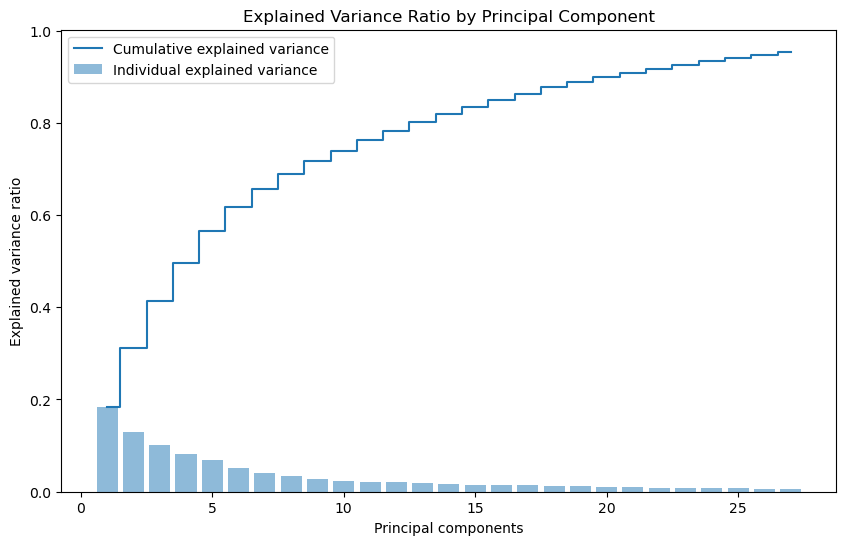

In [11]:
# Plotting the explained variance ratios
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

In [12]:
# Retrieve the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Remove the "cat__" and "num__" prefixes
clean_feature_names = [name.replace("cat__", "") for name in feature_names]
clean_feature_names = [name.replace("num__", "") for name in feature_names]

# Create DataFrame for PCA loadings
columns = [f'PC{i+1}' for i in range(pca.n_components_)]
pca_transformed_df = pd.DataFrame(X_pca, columns=columns)

# Create the loadings DataFrame using cleaned feature names
loadings = pd.DataFrame(pca.components_.T, columns=columns, index=clean_feature_names)

# Display the sorted loadings of each principal component
sorted_loadings = loadings.apply(lambda x: x.abs().sort_values(ascending=False), axis=0)
print(sorted_loadings.head())

# Create DataFrame for explained variance
explained_variance = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance'], index=columns)
print(explained_variance.head())

                 PC1       PC2       PC3       PC4       PC5       PC6  \
active.avg  0.065943  0.023755  0.014316  0.033947  0.003455  0.156551   
active.max  0.054229  0.004860  0.021165  0.058516  0.009570  0.135455   
active.min  0.077374  0.046700  0.008170  0.008837  0.001229  0.153063   
active.std  0.027646  0.008598  0.014878  0.051180  0.007750  0.100478   
active.tot  0.039700  0.023159  0.075542  0.204404  0.054456  0.104808   

                 PC7       PC8       PC9      PC10  ...      PC18      PC19  \
active.avg  0.451635  0.182153  0.083426  0.020038  ...  0.010956  0.003247   
active.max  0.443387  0.197078  0.143928  0.026947  ...  0.002758  0.008854   
active.min  0.332649  0.104154  0.022646  0.000173  ...  0.015968  0.021315   
active.std  0.409576  0.199558  0.172632  0.037139  ...  0.001256  0.017558   
active.tot  0.119042  0.054449  0.064853  0.025557  ...  0.000077  0.004845   

                PC20      PC21      PC22      PC23      PC24      PC25  \
active

# Model Implementation

In this section, we apply various machine learning algorithms to the PCA-transformed data. The classifiers chosen include Decision Tree, Random Forest, K-Nearest Neighbors (KNN), Support Vector Machine (SVM), and Boosting Methods (AdaBoost and XGBoost).

Although undersampling DOS_SYN_Hping somewhat alleviates the class imbalance, the issue of imbalanced data cannot be completely avoided, as there are only 28 total instances of the least frequently occurring class. However, high identification capacity for all classes is still of particular concern. Therefore, the models' performance will be evaluated using various performance metrics, including weighted averaged Precision, Recall, and F1-Score to account for class imbalance, with particular emphasis on the macro averages of these metrics to ensure high identification for all classes. 

The following implementations experiment with hyperparameter tuning using cross-validation and grid search technqiues. They also thoroughly compare different training vs. testing splits to provide a comprehensive understanding of the trade-offs within the data by adjusting these factors.

### Decision Tree

In the Decision Tree implementation, we compare a 70/30 training vs. testing split with an 80/20 training vs. testing split, and cross-validated results with direct hold-out results. In all cases, we utilize a balanced class weight approach to compensate for the data imbalance.

#### Cross-validation and grid search 70/30 split

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation Score: 0.9326803035266297
Test Set Performance:
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.97      0.97      2303
            DDOS_Slowloris       0.99      0.98      0.98       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       0.75      1.00      0.86         6
             NMAP_FIN_SCAN       0.62      1.00      0.76         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       1.00      0.99      1.00       319
             NMAP_UDP_SCAN       0.98      0.99      0.98       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
               Thing_Speak       0.97      0.98      0.98      2405
                

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

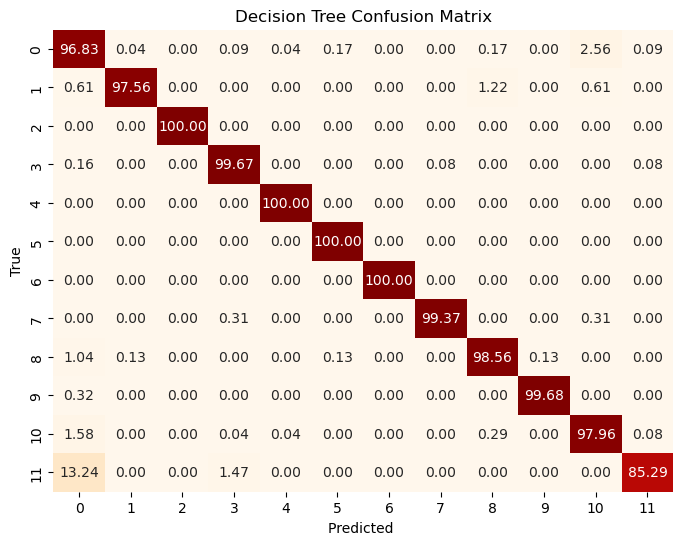

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5,10],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2,5]
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')

# Initialize GridSearchCV with Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print("Validation Score:", grid_search.best_score_)

# Evaluate on the test set
y_pred_test = grid_search.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_pred_test))

#confusion matrix 
conf_matrix_dt = confusion_matrix(y_test, y_pred_test)
#making it percent
cm_percent_DT = conf_matrix_dt / np.sum(conf_matrix_dt, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_DT, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')

#### Cross-validation and grid search 80/20 split

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation Score: 0.9351276520949418
Test Set Performance:
                            precision    recall  f1-score   support

            ARP_poisioning       0.96      0.96      0.96      1526
            DDOS_Slowloris       0.99      0.98      0.99       113
             DOS_SYN_Hping       1.00      1.00      1.00      1657
              MQTT_Publish       1.00      0.99      0.99       807
Metasploit_Brute_Force_SSH       0.80      1.00      0.89         4
             NMAP_FIN_SCAN       0.80      1.00      0.89         4
         NMAP_OS_DETECTION       1.00      1.00      1.00       401
             NMAP_TCP_scan       1.00      1.00      1.00       219
             NMAP_UDP_SCAN       0.99      0.99      0.99       536
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       393
               Thing_Speak       0.97      0.98      0.97      1613
                Wip

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

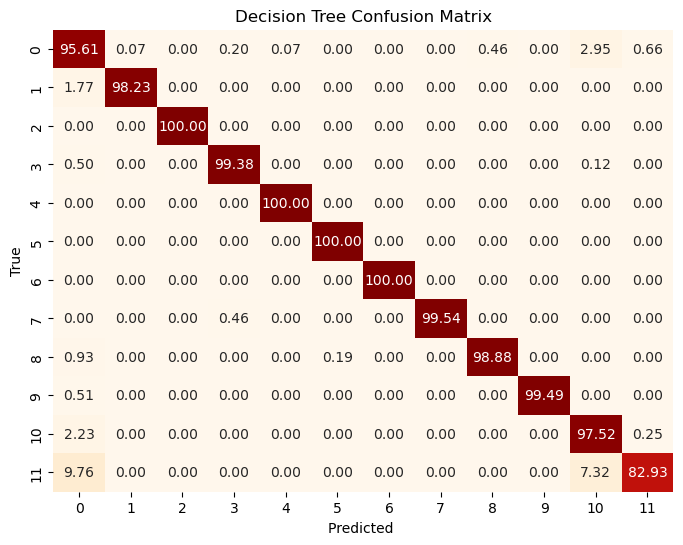

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2,5]
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')

# Initialize GridSearchCV with Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=3)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print("Validation Score:", grid_search.best_score_)

# Evaluate on the test set
y_pred_test = grid_search.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_pred_test))

#confusion matrix 
conf_matrix_dt = confusion_matrix(y_test, y_pred_test)
#making it percent
cm_percent_DT = conf_matrix_dt / np.sum(conf_matrix_dt, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_DT, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')

#### Direct hold-out 70/30 split

Accuracy: 0.9846855059252507
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.96      0.97      2303
            DDOS_Slowloris       0.98      0.98      0.98       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       0.86      1.00      0.92         6
             NMAP_FIN_SCAN       0.89      1.00      0.94         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       1.00      0.99      1.00       319
             NMAP_UDP_SCAN       0.99      0.99      0.99       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
               Thing_Speak       0.97      0.98      0.97      2405
                Wipro_bulb       0.80      0.87      0.83        68

                  accuracy                           0.98     10970
                 

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

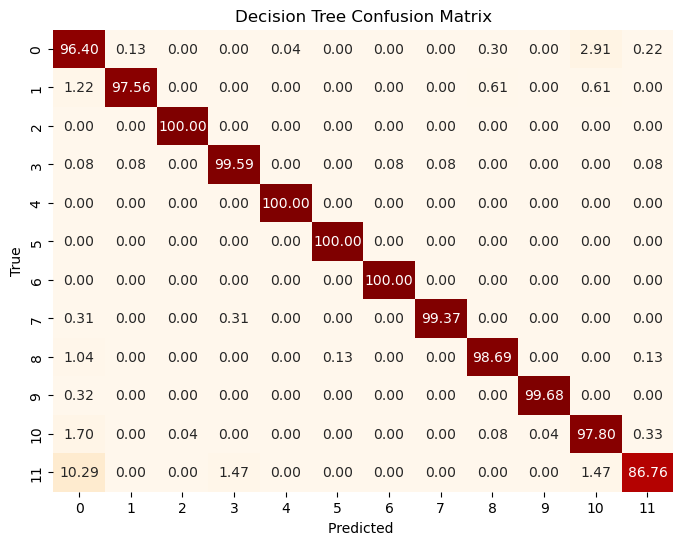

In [15]:
# Split the PCA transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42,class_weight='balanced')
dt_classifier.fit(X_train, y_train)

# Predict on the testing set and evaluate
y_pred_dt = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Print the results
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_dt))

#confusion matrix 
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
#making it percent
cm_percent_DT = conf_matrix_dt / np.sum(conf_matrix_dt, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_DT, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')

#### 70/30 split using best parameters

Accuracy: 0.9858705560619873
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.97      0.97      2303
            DDOS_Slowloris       0.99      0.98      0.98       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       0.75      1.00      0.86         6
             NMAP_FIN_SCAN       0.62      1.00      0.76         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       1.00      0.99      1.00       319
             NMAP_UDP_SCAN       0.98      0.99      0.98       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
               Thing_Speak       0.97      0.98      0.98      2405
                Wipro_bulb       0.92      0.85      0.89        68

                  accuracy                           0.99     10970
                 

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

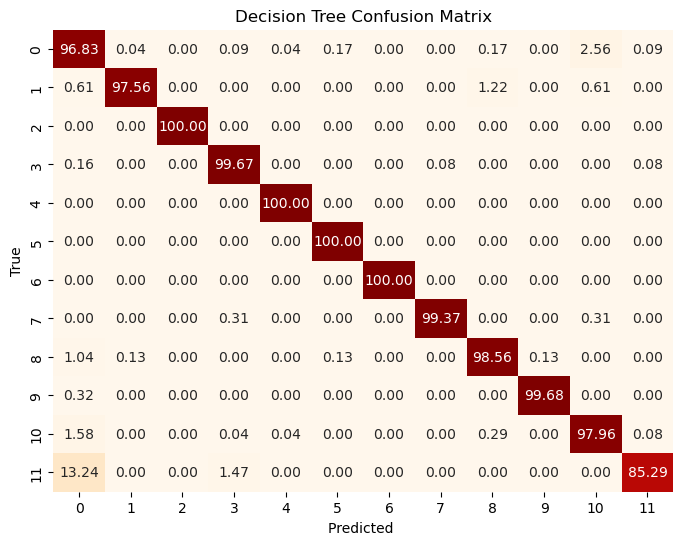

In [76]:
# Split the PCA transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42,criterion='entropy',class_weight='balanced')
dt_classifier.fit(X_train, y_train)

# Predict on the testing set and evaluate
y_pred_dt = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Print the results
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_dt))

#confusion matrix 
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
#making it percent
cm_percent_DT = conf_matrix_dt / np.sum(conf_matrix_dt, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_DT, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')

#### 80/20 split with best parameters

Accuracy: 0.9822258681979765
                            precision    recall  f1-score   support

            ARP_poisioning       0.96      0.96      0.96      1526
            DDOS_Slowloris       0.99      0.98      0.99       113
             DOS_SYN_Hping       1.00      1.00      1.00      1657
              MQTT_Publish       1.00      0.99      0.99       807
Metasploit_Brute_Force_SSH       0.80      1.00      0.89         4
             NMAP_FIN_SCAN       0.80      1.00      0.89         4
         NMAP_OS_DETECTION       1.00      1.00      1.00       401
             NMAP_TCP_scan       1.00      1.00      1.00       219
             NMAP_UDP_SCAN       0.99      0.99      0.99       536
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       393
               Thing_Speak       0.97      0.98      0.97      1613
                Wipro_bulb       0.71      0.83      0.76        41

                  accuracy                           0.98      7314
                 

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

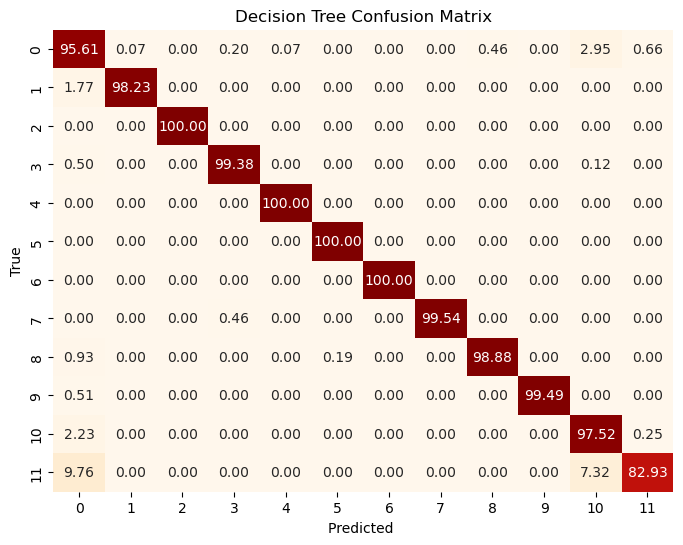

In [17]:
# Split the PCA transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42,class_weight='balanced')
dt_classifier.fit(X_train, y_train)

# Predict on the testing set and evaluate
y_pred_dt = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Print the results
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_dt))

#confusion matrix 
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
#making it percent
cm_percent_DT = conf_matrix_dt / np.sum(conf_matrix_dt, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_DT, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')

In [78]:
X, y = X_pca, y

split_1 = [(0.7, 0.3)]
results = []

for train_size, test_size in split_1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = DecisionTreeClassifier(random_state=42,criterion='entropy',class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
print("Decision Tree Best Parameter Classifier Summary")
print('-' * 40)
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)


split_2 = [(0.8, 0.2)]
results = []

for train_size, test_size in split_2:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = DecisionTreeClassifier(random_state=42,class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)
    

Decision Tree Best Parameter Classifier Summary
----------------------------------------
Train/Test Split: 70/30
Accuracy: 0.9859
Precision (Macro Avg): 0.9330
Recall (Macro Avg): 0.9791
F1-Score (Macro Avg): 0.9507
Precision (Weighted Avg): 0.9861
Recall (Weighted Avg): 0.9859
F1-Score (Weighted Avg): 0.9859
----------------------------------------
Train/Test Split: 80/20
Accuracy: 0.9822
Precision (Macro Avg): 0.9347
Recall (Macro Avg): 0.9763
F1-Score (Macro Avg): 0.9532
Precision (Weighted Avg): 0.9825
Recall (Weighted Avg): 0.9822
F1-Score (Weighted Avg): 0.9823
----------------------------------------


Both splits yield high accuracies, indicating that the Decision Tree model is performing well. However, the fact that the individual class precision of the least frequently occuring classes (Metasploit_Brute_Force_SSH and NMAP_FIN_SCAN) in the 70/30 split fell when the best parameters were used indicates a trade-off between individual class precision, overall accuracy and macro average precision, especially in the context of imbalanced datasets. Overall, the slightly better performance of the 70/30 split may suggest that the model overfits less with the larger test set, improving the generalizability of the data. For the next models observed, cross-validated implementations will be prioritized to ensure model stability and hyperparameter optimization.


Next, to gauge which features in the original dataset were most
pertinent to the Decision Tree predictions,
the 'feature_importances_' attribute, which contain an array of values that correspond to the importance of each feature,was accessed. Given that the algorithms were performed on PCA-transformed data, the output would indicate, not specific features, but instead, the most important principal components.

   Feature  Importance
4      PC5    0.153161
8      PC9    0.123041
3      PC4    0.104436
15    PC16    0.082313
2      PC3    0.081215
1      PC2    0.067740
19    PC20    0.064925
9     PC10    0.050056
7      PC8    0.041296
6      PC7    0.038875
0      PC1    0.033192
17    PC18    0.031091
12    PC13    0.019822
23    PC24    0.019523
13    PC14    0.018906
5      PC6    0.015072
14    PC15    0.011063
26    PC27    0.009232
25    PC26    0.007737
10    PC11    0.007130
16    PC17    0.006767
22    PC23    0.004647
21    PC22    0.002653
18    PC19    0.002475
24    PC25    0.002342
20    PC21    0.001262
11    PC12    0.000026


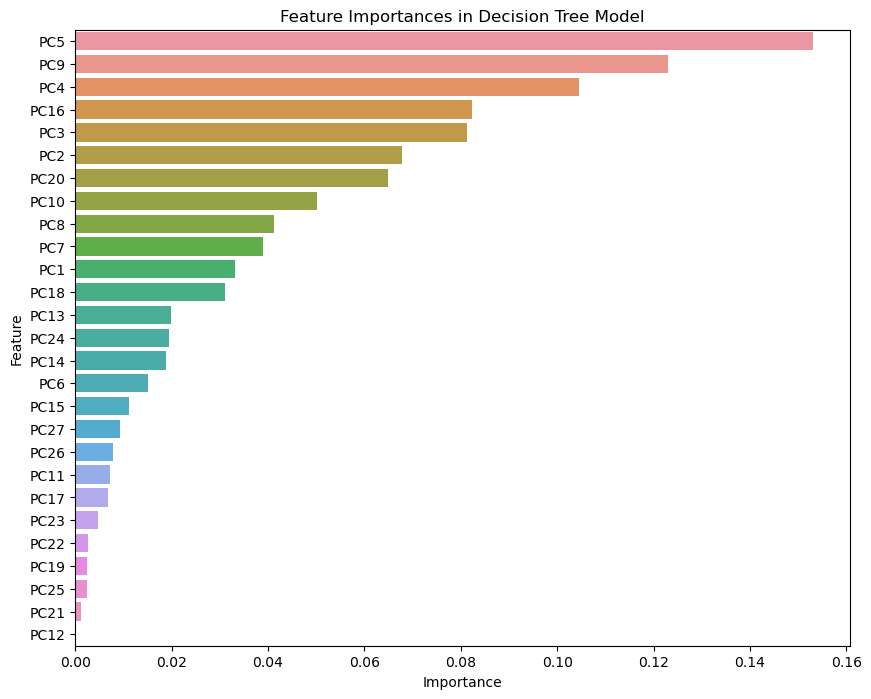

In [18]:
n_components = X_test.shape[1]
feature_names = [f'PC{i+1}' for i in range(n_components)]

# Get feature importances from the Decision Tree model
feature_importances_dt = dt_classifier.feature_importances_
importances_df_dt = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_dt})

# Sort the DataFrame by importance
importances_df_dt = importances_df_dt.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(importances_df_dt)

# Visualize the feature importances for the Decision Tree model
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df_dt)
plt.title('Feature Importances in Decision Tree Model')
plt.show()

### Random Forest

For this method, some hyperparameters from the Decision Tree were reused in order to reduce the computational load, while others had to be optimized specifically for the ensemble method. The optimized parameters were 'n_estimators','bootstrap', and 'class_weight'. Both 80/20 and 70/30 training vs. testing splits were studied.

#### Cross-validation and grid search 70/30 split

In [81]:
# Split the PCA transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Map Decision Tree parameters to Random Forest parameters
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': [grid_search.best_params_['criterion']],
    'max_depth': [grid_search.best_params_['max_depth']],
    'min_samples_split': [grid_search.best_params_['min_samples_split']],
    'min_samples_leaf': [grid_search.best_params_['min_samples_leaf']],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV to training data
grid_search_rf.fit(X_train, y_train)

# Best parameters for Random Forest
print("Best Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate on the test data
accuracy_rf = grid_search_rf.score(X_test, y_test)
print(f"Test Accuracy: {accuracy_rf:.4f}")

# Classification report
y_pred_rf = grid_search_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Best Parameters for Random Forest:
{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test Accuracy: 0.9802
Classification Report:
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.99      0.98      2303
            DDOS_Slowloris       1.00      0.98      0.99       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       0.86      1.00      0.92         6
             NMAP_FIN_SCAN       1.00      1.00      1.00         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       1.00      0.99      1.00       319
             NMAP_UDP_SCAN       1.00      0.99      0.99       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
   

#### Cross-validation and grid search 80/20 split

In [85]:
# Split the PCA transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Map Decision Tree parameters to Random Forest parameters
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': [grid_search.best_params_['criterion']],
    'max_depth': [grid_search.best_params_['max_depth']],
    'min_samples_split': [grid_search.best_params_['min_samples_split']],
    'min_samples_leaf': [grid_search.best_params_['min_samples_leaf']],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV to training data
grid_search_rf.fit(X_train, y_train)

# Best parameters for Random Forest
print("Best Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate on the test data
accuracy_rf = grid_search_rf.score(X_test, y_test)
print(f"Test Accuracy: {accuracy_rf:.4f}")

# Classification report
y_pred_rf = grid_search_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Best Parameters for Random Forest:
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.9738
Classification Report:
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.99      0.98      1526
            DDOS_Slowloris       0.99      0.99      0.99       113
             DOS_SYN_Hping       1.00      1.00      1.00      1657
              MQTT_Publish       1.00      1.00      1.00       807
Metasploit_Brute_Force_SSH       0.80      1.00      0.89         4
             NMAP_FIN_SCAN       1.00      1.00      1.00         4
         NMAP_OS_DETECTION       1.00      1.00      1.00       401
             NMAP_TCP_scan       1.00      1.00      1.00       219
             NMAP_UDP_SCAN       1.00      0.99      0.99       536
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       393
               

#### Direct hold-out 70/30 split using best parameters

In [90]:
# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier with the best parameters
random_forest_model = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    class_weight='balanced_subsample',
    bootstrap=True,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2
)

# Train the model
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=50, random_state=42)

Accuracy: 0.9896991795806745
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.99      0.98      2303
            DDOS_Slowloris       1.00      0.98      0.99       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       0.86      1.00      0.92         6
             NMAP_FIN_SCAN       1.00      1.00      1.00         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       1.00      0.99      1.00       319
             NMAP_UDP_SCAN       1.00      0.99      0.99       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
               Thing_Speak       0.99      0.98      0.98      2405
                Wipro_bulb       0.97      0.85      0.91        68

                  accuracy                           0.99     10970
                 

Text(0.5, 1.0, 'Random Forest Tree Confusion Matrix')

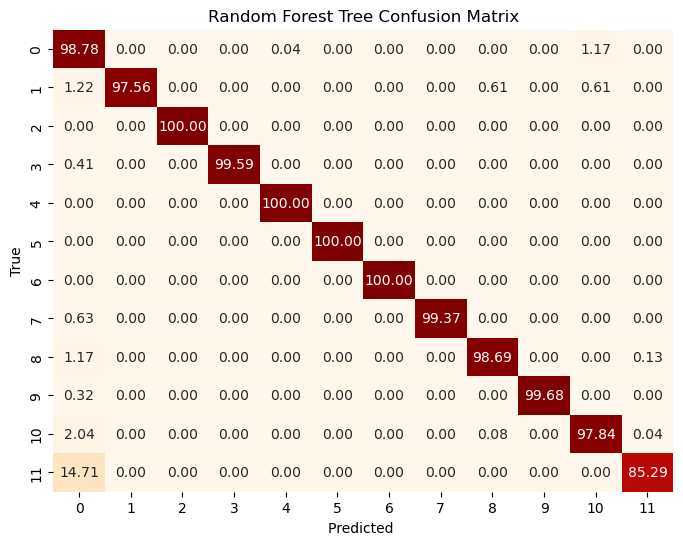

In [91]:
# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred_rf))

#confusion matrix 
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
#making it percent
cm_percent_RFF = conf_matrix_rf / np.sum(conf_matrix_rf, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_RFF, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Random Forest Tree Confusion Matrix')

#### Direct hold-out 80/20 split using best parameters

In [66]:
 #X_pca is PCA-transformed features and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced', bootstrap=False)

# Train the model
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       n_estimators=200, random_state=42)

Accuracy: 0.9911577028258888
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.99      0.98      2303
            DDOS_Slowloris       0.99      0.99      0.99       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       0.86      1.00      0.92         6
             NMAP_FIN_SCAN       0.89      1.00      0.94         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       1.00      1.00      1.00       319
             NMAP_UDP_SCAN       0.99      0.99      0.99       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
               Thing_Speak       0.99      0.98      0.99      2405
                Wipro_bulb       0.95      0.85      0.90        68

                  accuracy                           0.99     10970
                 

Text(0.5, 1.0, 'Random Forest Tree Confusion Matrix')

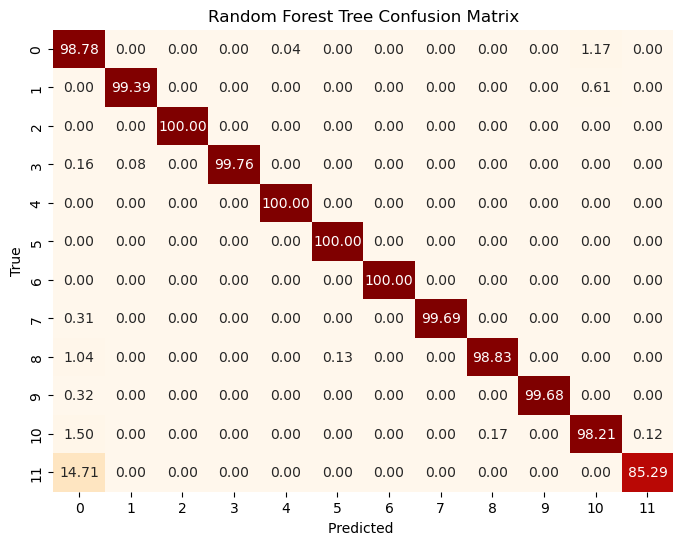

In [67]:
# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred_rf))

#confusion matrix 
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
#making it percent
cm_percent_RFF = conf_matrix_rf / np.sum(conf_matrix_rf, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_RFF, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('Random Forest Tree Confusion Matrix')

In [92]:
X, y = X_pca, y
random_forest_model = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    class_weight='balanced_subsample',
    bootstrap=True,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2
)


split_1 = [(0.7, 0.3)]
results = []

for train_size, test_size in split_1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = random_forest_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
print("Random Forest Best Parameter Classifier Summary")
print('-' * 40)
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)


split_2 = [(0.8, 0.2)]
results = []

for train_size, test_size in split_2:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced', bootstrap=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)
    

Random Forest Best Parameter Classifier Summary
----------------------------------------
Train/Test Split: 70/30
Accuracy: 0.9897
Precision (Macro Avg): 0.9812
Recall (Macro Avg): 0.9807
F1-Score (Macro Avg): 0.9802
Precision (Weighted Avg): 0.9898
Recall (Weighted Avg): 0.9897
F1-Score (Weighted Avg): 0.9897
----------------------------------------
Train/Test Split: 80/20
Accuracy: 0.9911
Precision (Macro Avg): 0.9559
Recall (Macro Avg): 0.9816
F1-Score (Macro Avg): 0.9667
Precision (Weighted Avg): 0.9912
Recall (Weighted Avg): 0.9911
F1-Score (Weighted Avg): 0.9911
----------------------------------------


When the best parameters are used, the 70/30 and 80/20 splits yield high overall accuracy and weighted metrics, with the advantage going to 80/20, indicating a strong performance due to the dominance of the majority classes. The slightly better performance of the 70/30 split in terms of precision and F1-score macro averages may suggest that, despite having the smaller training set, this split may generalize the data better. Additionally, Random Forest consistently outperforms Decision Tree across all metrics. Although these differences are marginal, they are still worth noting for high-stakes classification tasks requiring robust predictions.

We repeat the process of determining the most pertinent principal components of the Random Forest model.

   Feature  Importance
4      PC5    0.153161
8      PC9    0.123041
3      PC4    0.104436
15    PC16    0.082313
2      PC3    0.081215
1      PC2    0.067740
19    PC20    0.064925
9     PC10    0.050056
7      PC8    0.041296
6      PC7    0.038875
0      PC1    0.033192
17    PC18    0.031091
12    PC13    0.019822
23    PC24    0.019523
13    PC14    0.018906
5      PC6    0.015072
14    PC15    0.011063
26    PC27    0.009232
25    PC26    0.007737
10    PC11    0.007130
16    PC17    0.006767
22    PC23    0.004647
21    PC22    0.002653
18    PC19    0.002475
24    PC25    0.002342
20    PC21    0.001262
11    PC12    0.000026


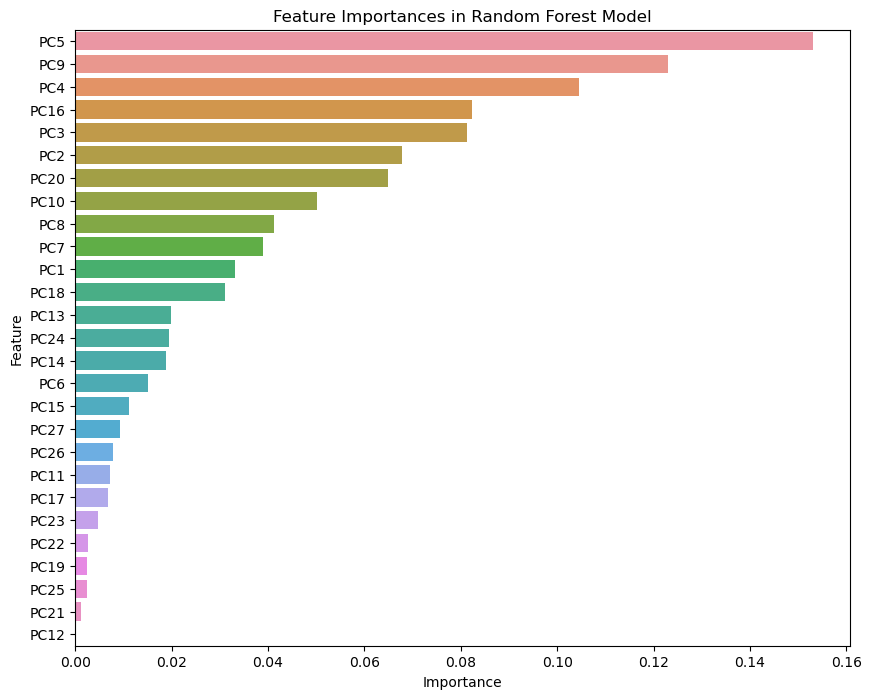

In [30]:
n_components = X_test.shape[1]
feature_names = [f'PC{i+1}' for i in range(n_components)]

# Get feature importances from the Decision Tree model
feature_importances_rf = random_forest_model.feature_importances_
importances_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_rf})

# Sort the DataFrame by importance
importances_df_rf = importances_df_dt.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(importances_df_rf)

# Visualize the feature importances for the Decision Tree model
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df_dt)
plt.title('Feature Importances in Random Forest Model')
plt.show()


### Feature Relevance in Decision Tree and Random Forest Models

The Feature Importances charts yielded identical results for the Decision Tree and Random Forest models, which is reasonable seeing as how the latter algorithm is an ensemble of the former. We investigate the top three principal components below to extract, first the top five rows that contributed most to that principal component, and then the top five features associated with that individidual row. This would help gauge which features were of highest impact to the algorithms employed, and of particular significance in the context of cybersecurity in general.

#### PC5 Investigation

In [23]:
pca_transformed_df_sorted = pca_transformed_df.sort_values(by='PC5', ascending=False)
pca_transformed_df_sorted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
20614,59.444423,39.296169,88.853555,200.930149,49.508186,-45.201376,-17.718608,8.440838,-38.040850,-4.798727,...,-3.610670,1.935282,1.337151,-0.598157,-2.126357,1.085754,-3.471363,6.796453,-0.386434,11.476452
20528,48.862365,32.562245,74.097360,167.770883,40.812506,-38.433538,-11.134668,5.766381,-32.356172,-4.477039,...,-2.799964,1.552823,1.365831,-0.242347,-0.499415,0.186897,-3.117820,3.726390,-1.422070,6.085934
20613,61.256820,12.484643,74.024161,134.570786,30.498637,-6.274087,-64.124161,-31.363781,5.068217,6.929630,...,-4.202135,0.907956,-2.057987,2.345421,-7.152530,6.982370,6.954940,0.210520,1.922619,4.556778
20527,58.608317,11.073773,70.344335,127.229217,28.596600,-5.984429,-58.232854,-31.135409,5.536167,6.013838,...,-3.953028,1.194395,-2.344019,2.223590,-4.731036,7.106338,6.215686,0.795229,1.109622,4.769303
20393,28.174421,19.204384,45.728653,105.169492,24.354286,-28.213323,9.186405,-2.410142,-22.265948,-5.215942,...,-0.695073,0.818522,1.964953,0.361627,4.886170,-2.461310,-3.070579,-5.106411,-4.396408,-12.319300


##### Gleaning Key Features from PC5

In [24]:
# New indices for which want to identify the most significant original features
new_indices = [20614, 20528, 20613, 20527, 20393]

# Access the specific rows for the new indices
specific_rows_new = pca_transformed_df_sorted.loc[new_indices]

# Perform the dot product tExo map back to the original features' space
approx_original_contributions_new = specific_rows_new.dot(loadings.T)

# Identify the most significant original features for each of the new indices
most_significant_features_new = approx_original_contributions_new.apply(lambda x: x.abs().nlargest(5).index.tolist(), axis=1)
most_significant_features_new = most_significant_features_new.apply(lambda x: [feature.replace('num__', '') for feature in x])

# Convert the series to a DataFrame for better display and analysis
significant_features_df_new = pd.DataFrame(most_significant_features_new.tolist(), index=most_significant_features_new.index, columns=[f'Feature {i+1}' for i in range(len(most_significant_features_new.iloc[0]))])

# Display the full DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(significant_features_df_new)


               Feature 1     Feature 2      Feature 3             Feature 4  \
20614  fwd_data_pkts_tot  fwd_pkts_tot    fwd_iat.tot         flow_duration   
20528  fwd_data_pkts_tot  fwd_pkts_tot    fwd_iat.tot         flow_duration   
20613        bwd_iat.tot      idle.tot  flow_duration          flow_iat.tot   
20527        bwd_iat.tot      idle.tot  flow_duration          flow_iat.tot   
20393  fwd_data_pkts_tot    active.tot   fwd_pkts_tot  fwd_pkts_payload.tot   

          Feature 5  
20614  flow_iat.tot  
20528  flow_iat.tot  
20613   fwd_iat.tot  
20527   fwd_iat.tot  
20393   fwd_iat.tot  


#### PC9 Investigation

In [31]:
pca_transformed_df_sorted = pca_transformed_df.sort_values(by='PC9', ascending=False)
pca_transformed_df_sorted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
27526,59.957373,-58.358372,46.082506,-2.640816,-18.853789,84.326845,-3.163566,-33.521854,59.466490,-31.105812,...,26.186239,4.441969,-3.481778,0.052356,-14.077129,9.785050,8.343465,-15.486145,6.749790,8.311405
28361,59.956522,-58.357963,46.081584,-2.641887,-18.853849,84.327972,-3.170274,-33.517969,59.463059,-31.104122,...,26.184535,4.441852,-3.481241,0.052333,-14.077708,9.780614,8.340847,-15.483994,6.748373,8.310611
34555,26.892071,4.967822,19.051345,46.784093,8.145279,-63.298396,195.160176,-81.887398,55.397633,-14.197698,...,-0.791240,-4.656754,-3.758929,-7.718100,60.643565,78.547782,22.141731,-6.411563,0.504709,13.705026
21307,32.076427,29.232589,-12.095445,40.639352,7.415933,25.885287,52.887984,160.460654,55.108399,-11.875654,...,-32.138395,1.042106,12.433716,6.482717,6.583099,4.119739,-3.861338,-3.179752,-3.690206,-14.700089
28314,33.014478,29.974666,-14.305068,39.948828,6.890561,26.475889,51.670866,158.353472,53.846210,-12.150849,...,-31.671384,1.746657,12.110994,6.933253,6.260424,4.087046,-3.860337,-2.722147,-3.905124,-15.116637


##### Gleaning Key Features from PC9

In [32]:
# New indices for which want to identify the most significant original features
new_indices = [27526, 28361, 34555, 21307, 28314]

# Access the specific rows for the new indices
specific_rows_new = pca_transformed_df_sorted.loc[new_indices]

# Perform the dot product tExo map back to the original features' space
approx_original_contributions_new = specific_rows_new.dot(loadings.T)

# Identify the most significant original features for each of the new indices
most_significant_features_new = approx_original_contributions_new.apply(lambda x: x.abs().nlargest(5).index.tolist(), axis=1)
most_significant_features_new = most_significant_features_new.apply(lambda x: [feature.replace('num__', '') for feature in x])

# Convert the series to a DataFrame for better display and analysis
significant_features_df_new = pd.DataFrame(most_significant_features_new.tolist(), index=most_significant_features_new.index, columns=[f'Feature {i+1}' for i in range(len(most_significant_features_new.iloc[0]))])

# Display the full DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(significant_features_df_new)


            Feature 1         Feature 2          Feature 3  \
27526     fwd_iat.min       fwd_iat.avg        bwd_iat.std   
28361     fwd_iat.min       fwd_iat.avg        bwd_iat.std   
34555      active.std        active.max         active.avg   
21307  fwd_bulk_bytes  fwd_bulk_packets  fwd_subflow_bytes   
28314  fwd_bulk_bytes  fwd_bulk_packets  fwd_subflow_bytes   

                  Feature 4             Feature 5  
27526           bwd_iat.avg          flow_iat.avg  
28361           bwd_iat.avg          flow_iat.avg  
34555            active.tot     fwd_data_pkts_tot  
21307  fwd_pkts_payload.tot  fwd_pkts_payload.avg  
28314  fwd_pkts_payload.tot  fwd_pkts_payload.avg  


#### PC4 Investigation

In [25]:
pca_transformed_df_sorted_4 = pca_transformed_df.sort_values(by='PC4', ascending=False)
pca_transformed_df_sorted_4.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
20614,59.444423,39.296169,88.853555,200.930149,49.508186,-45.201376,-17.718608,8.440838,-38.040850,-4.798727,...,-3.610670,1.935282,1.337151,-0.598157,-2.126357,1.085754,-3.471363,6.796453,-0.386434,11.476452
20528,48.862365,32.562245,74.097360,167.770883,40.812506,-38.433538,-11.134668,5.766381,-32.356172,-4.477039,...,-2.799964,1.552823,1.365831,-0.242347,-0.499415,0.186897,-3.117820,3.726390,-1.422070,6.085934
20613,61.256820,12.484643,74.024161,134.570786,30.498637,-6.274087,-64.124161,-31.363781,5.068217,6.929630,...,-4.202135,0.907956,-2.057987,2.345421,-7.152530,6.982370,6.954940,0.210520,1.922619,4.556778
20527,58.608317,11.073773,70.344335,127.229217,28.596600,-5.984429,-58.232854,-31.135409,5.536167,6.013838,...,-3.953028,1.194395,-2.344019,2.223590,-4.731036,7.106338,6.215686,0.795229,1.109622,4.769303
20425,28.174421,19.204384,45.728653,105.169492,24.354286,-28.213323,9.186405,-2.410142,-22.265948,-5.215942,...,-0.695073,0.818522,1.964953,0.361627,4.886170,-2.461310,-3.070579,-5.106411,-4.396408,-12.319300


##### Gleaning Key Features From PC4

In [26]:
# New indices for which we want to identify the most significant original features
new_indices_4 = [20614, 20528, 20613, 20527, 20425]

# Access the specific rows for the new indices
specific_rows_new_4 = pca_transformed_df_sorted_4.loc[new_indices_4]

# Perform the dot product to map back to the original features' space
approx_original_contributions_new_4 = specific_rows_new_4.dot(loadings.T)

# Identify the most significant original features for each of the new indices
most_significant_features_new_4 = approx_original_contributions_new_4.apply(lambda x: x.abs().nlargest(5).index.tolist(), axis=1)
most_significant_features_new_4 = most_significant_features_new_4.apply(lambda x: [feature.replace('num__', '') for feature in x])

# Convert the series to a DataFrame for better display and analysis
significant_features_df_new_4 = pd.DataFrame(most_significant_features_new_4.tolist(), index=most_significant_features_new_4.index, columns=[f'Feature {i+1}' for i in range(len(most_significant_features_new_4.iloc[0]))])

# Display the full DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(significant_features_df_new_4)


               Feature 1     Feature 2      Feature 3             Feature 4  \
20614  fwd_data_pkts_tot  fwd_pkts_tot    fwd_iat.tot         flow_duration   
20528  fwd_data_pkts_tot  fwd_pkts_tot    fwd_iat.tot         flow_duration   
20613        bwd_iat.tot      idle.tot  flow_duration          flow_iat.tot   
20527        bwd_iat.tot      idle.tot  flow_duration          flow_iat.tot   
20425  fwd_data_pkts_tot    active.tot   fwd_pkts_tot  fwd_pkts_payload.tot   

          Feature 5  
20614  flow_iat.tot  
20528  flow_iat.tot  
20613   fwd_iat.tot  
20527   fwd_iat.tot  
20425   fwd_iat.tot  


##### Finding Common Features Across PC5, PC9, and PC4

In [38]:
# Define data as dictionaries
data_1 = {
    'Feature 1': ['fwd_data_pkts_tot', 'fwd_data_pkts_tot', 'bwd_iat.tot', 'bwd_iat.tot', 'fwd_data_pkts_tot'],
    'Feature 2': ['fwd_pkts_tot', 'fwd_pkts_tot', 'idle.tot', 'idle.tot', 'active.tot'],
    'Feature 3': ['fwd_iat.tot', 'fwd_iat.tot', 'flow_duration', 'flow_duration', 'fwd_pkts_tot'],
    'Feature 4': ['flow_duration', 'flow_duration', 'flow_iat.tot', 'flow_iat.tot', 'fwd_pkts_payload.tot'],
    'Feature 5': ['flow_iat.tot', 'flow_iat.tot', 'fwd_iat.tot', 'fwd_iat.tot', 'fwd_iat.tot']
}

data_2 = {
    'Feature 1': ['fwd_iat.min', 'fwd_iat.min', 'active.std', 'fwd_bulk_bytes', 'fwd_bulk_bytes'],
    'Feature 2': ['fwd_iat.avg', 'fwd_iat.avg', 'active.max', 'fwd_bulk_packets', 'fwd_bulk_packets'],
    'Feature 3': ['bwd_iat.std', 'bwd_iat.std', 'active.avg', 'fwd_subflow_bytes', 'fwd_subflow_bytes'],
    'Feature 4': ['bwd_iat.avg', 'bwd_iat.avg', 'active.tot', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.tot'],
    'Feature 5': ['flow_iat.avg', 'flow_iat.avg', 'fwd_data_pkts_tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.avg']
}

data_3 = {
    'Feature 1': ['fwd_data_pkts_tot', 'fwd_data_pkts_tot', 'bwd_iat.tot', 'bwd_iat.tot', 'fwd_data_pkts_tot'],
    'Feature 2': ['fwd_pkts_tot', 'fwd_pkts_tot', 'idle.tot', 'idle.tot', 'active.tot'],
    'Feature 3': ['fwd_iat.tot', 'fwd_iat.tot', 'flow_duration', 'flow_duration', 'fwd_pkts_tot'],
    'Feature 4': ['flow_duration', 'flow_duration', 'flow_iat.tot', 'flow_iat.tot', 'fwd_pkts_payload.tot'],
    'Feature 5': ['flow_iat.tot', 'flow_iat.tot', 'fwd_iat.tot', 'fwd_iat.tot', 'fwd_iat.tot']
}



# Convert dictionaries to DataFrames
df1 = pd.DataFrame(data_1)
df2 = pd.DataFrame(data_2)
df3 = pd.DataFrame(data_3)

# Flatten the DataFrames into sets of features
features_set_1 = set(df1.values.flatten())
features_set_2 = set(df2.values.flatten())
features_set_3 = set(df3.values.flatten())

# Find the intersection of the three sets
common_features = features_set_1.intersection(features_set_2).intersection(features_set_3)

# Convert the set to a list and sort it for display
sorted_features = sorted(list(common_features))

# Create a DataFrame with an index column for better readability
df = pd.DataFrame(sorted_features, columns=['Common Features Across PC5, PC9, and PC4'])
df.index += 1  # Start the index at 1 instead of 0

# Display the DataFrame
print(df)

print("Number of common features:", len(common_features))

# Find the union of the two sets
all_unique_features = features_set_1.union(features_set_2)

# Print the number of unique features
print("Number of unique features in either data_1, data_2, or data_3:", len(all_unique_features))

print()
print()
# Find the common features across any two of the three sets
common_features_1_and_2 = features_set_1.intersection(features_set_2)
common_features_1_and_3 = features_set_1.intersection(features_set_3)
common_features_2_and_3 = features_set_2.intersection(features_set_3)

# Union of all common features from any two sets
common_features_any_two = common_features_1_and_2.union(common_features_1_and_3).union(common_features_2_and_3)

# Convert the set to a list and sort it for display
sorted_features_2_outof_3 = sorted(list(common_features_any_two))

# Create a DataFrame with an index column for better readability
df = pd.DataFrame(sorted_features_2_outof_3, columns=['Common Features Across Any Two PCs'])
df.index += 1  # Start the index at 1 instead of 0

# Display the DataFrame
print(df)

print("Number of common features:", len(common_features_any_two))

# Find the union of the two sets
all_unique_features = features_set_1.union(features_set_2).union(features_set_3)

# Print the number of unique features
print("Number of unique features in either data_1, data_2 or data_3:", len(all_unique_features))



  Common Features Across PC5, PC9, and PC4
1                               active.tot
2                        fwd_data_pkts_tot
3                     fwd_pkts_payload.tot
Number of common features: 3
Number of unique features in either data_1, data_2, or data_3: 21


  Common Features Across Any Two PCs
1                         active.tot
2                        bwd_iat.tot
3                      flow_duration
4                       flow_iat.tot
5                  fwd_data_pkts_tot
6                        fwd_iat.tot
7               fwd_pkts_payload.tot
8                       fwd_pkts_tot
9                           idle.tot
Number of common features: 9
Number of unique features in either data_1, data_2 or data_3: 21


- Forward-Direction Features:
  - fwd_data_pkts_tot (Total Forward Data Packets)
  - fwd_iat.tot (Total Forward Inter-Arrival Time)
  - fwd_pkts_payload.tot (Total Payload of Forward Packets)
  - fwd_pkts_tot (Total Forward Packets)

- Backward-Direction Features:
  - bwd_iat.tot (Total Backward Inter-Arrival Time)

- Bidirectional/Overall Features:
  - flow_duration (Flow Duration)
  - flow_iat.tot (Total Flow Inter-Arrival Time)
  - active.tot (Total Active Time)
  - idle.tot (Total Idle Time)


Out of the nine most significant features, four directly relate to the forward direction, while only one directly relates to the backward direction. Forward traffic often initiates the connection and contains data crucial to identify anomalies. For example, forward packets' payloads can help identify data exfiltration attempts or legitimate data transfers and Inter-arrival times of forward packets can indicate stealthy communication attempts or DoS attacks. Though fewer significant backward-direction features were identified, the inter-arrival time of backward packets (`bwd_iat.tot`) remains crucial for analyzing response patterns. Backward traffic often contains responses to forward requests, helping to identify abnormal communication patterns (e.g., slow responses in botnet command-and-control). As such, in the context of cybersecurity, forward packets can help identify scanning attempts, data exfiltration, and DoS attacks and backward packets complement forward packet insights by revealing server behavior, response times, and abnormal connections.



### KNN

For this implementation, we compare the same training vs. testing splits previously utilized, 70/30 and 80/20, and attempt to find an optimal value of 'k' neighbors using a cross-validation approach. Additionally, we examine the effect of using 'distance' as the weight measure as opposed to a uniform measure.

#### For n=3 neighbors, uniform weight:

In [33]:
# Simulated dataset (replace with your actual dataset)
X, y = X_pca, y

splits = [(0.7, 0.3), (0.8, 0.2)]
results = []

for train_size, test_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
print("n=3 KNN Classifier Summary")
print('-' * 40)
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)


n=3 KNN Classifier Summary
----------------------------------------
Train/Test Split: 70/30
Accuracy: 0.9879
Precision (Macro Avg): 0.9607
Recall (Macro Avg): 0.9669
F1-Score (Macro Avg): 0.9635
Precision (Weighted Avg): 0.9879
Recall (Weighted Avg): 0.9879
F1-Score (Weighted Avg): 0.9879
----------------------------------------
Train/Test Split: 80/20
Accuracy: 0.9878
Precision (Macro Avg): 0.9456
Recall (Macro Avg): 0.9629
F1-Score (Macro Avg): 0.9533
Precision (Weighted Avg): 0.9879
Recall (Weighted Avg): 0.9878
F1-Score (Weighted Avg): 0.9879
----------------------------------------


#### For n=3 neighbors, 'distance' weight:

In [34]:
# Simulated dataset (replace with your actual dataset)
X, y = X_pca, y

splits = [(0.7, 0.3), (0.8, 0.2)]
results = []

for train_size, test_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = KNeighborsClassifier(n_neighbors=3, weights='distance')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
print("n=3 KNN Classifier Summary")
print('-' * 40)
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)


n=3 KNN Classifier Summary
----------------------------------------
Train/Test Split: 70/30
Accuracy: 0.9892
Precision (Macro Avg): 0.9752
Recall (Macro Avg): 0.9848
F1-Score (Macro Avg): 0.9796
Precision (Weighted Avg): 0.9893
Recall (Weighted Avg): 0.9892
F1-Score (Weighted Avg): 0.9893
----------------------------------------
Train/Test Split: 80/20
Accuracy: 0.9893
Precision (Macro Avg): 0.9682
Recall (Macro Avg): 0.9905
F1-Score (Macro Avg): 0.9783
Precision (Weighted Avg): 0.9894
Recall (Weighted Avg): 0.9893
F1-Score (Weighted Avg): 0.9894
----------------------------------------


In both the 70/30 and 80/20 splits with `k=3`, all metrics obtained by setting `weights='distance'` were slightly better than those when `weights='uniform'`. Therefore, we will proceed with cross-validating `k` using `weights='distance'` instead of uniform weight distribution.

#### Cross-validated K-value 70/30 split

In [122]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Define a range of k values to try
param_grid = {'n_neighbors': range(1, 30)}

# Set up GridSearchCV to find the best k
grid = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

# Best parameter and score
print("Best k-value found: ", grid.best_params_)
print("Best cross-validated score: ", grid.best_score_)

Best k-value found:  {'n_neighbors': 5}
Best cross-validated score:  0.9512021614184855


In [106]:
# Instantiate the model with distance weighting
knn_weighted_2 = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Fit the model on your training data
knn_weighted_2.fit(X_train, y_train)

# Predict using the model
y_pred_2 = knn_weighted_2.predict(X_test)

Accuracy: 0.9878760255241568
                            precision    recall  f1-score   support

            ARP_poisioning       0.97      0.98      0.97      2303
            DDOS_Slowloris       0.99      0.99      0.99       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       0.86      1.00      0.92         6
             NMAP_FIN_SCAN       1.00      1.00      1.00         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       1.00      0.99      1.00       319
             NMAP_UDP_SCAN       1.00      0.99      0.99       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
               Thing_Speak       0.98      0.98      0.98      2405
                Wipro_bulb       0.89      0.87      0.88        68

                  accuracy                           0.99     10970
                 

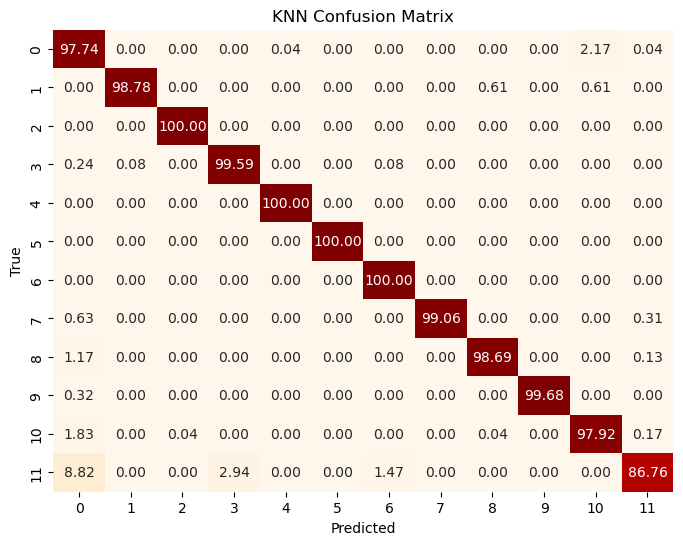

In [107]:
# Evaluate the model
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Accuracy: {accuracy_2}")
print(classification_report(y_test, y_pred_2))

# Compute the confusion matrix
conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_2)

# Convert confusion matrix to percentages
cm_percent_KNN_2 = conf_matrix_knn_2 / np.sum(conf_matrix_knn_2, axis=1, keepdims=True) * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_KNN_2, annot=True, cmap='OrRd', fmt=".2f", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

#### Cross-validated K-value 80/20 split

In [108]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define a range of k values to try
param_grid = {'n_neighbors': range(1, 30)}

# Set up GridSearchCV to find the best k
grid = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

# Best parameter and score
print("Best k-value found: ", grid.best_params_)
print("Best cross-validated score: ", grid.best_score_)

Best k-value found:  {'n_neighbors': 3}
Best cross-validated score:  0.9591488933982903


In [117]:
# Instantiate the model with distance weighting
knn_weighted_2 = KNeighborsClassifier(n_neighbors=3, weights='distance')

# Fit the model on your training data
knn_weighted_2.fit(X_train, y_train)

# Predict using the model
y_pred_2 = knn_weighted_2.predict(X_test)

Accuracy: 0.9893355209187858
                            precision    recall  f1-score   support

            ARP_poisioning       0.98      0.97      0.98      1526
            DDOS_Slowloris       0.98      1.00      0.99       113
             DOS_SYN_Hping       1.00      1.00      1.00      1657
              MQTT_Publish       1.00      1.00      1.00       807
Metasploit_Brute_Force_SSH       0.80      1.00      0.89         4
             NMAP_FIN_SCAN       1.00      1.00      1.00         4
         NMAP_OS_DETECTION       1.00      1.00      1.00       401
             NMAP_TCP_scan       1.00      1.00      1.00       219
             NMAP_UDP_SCAN       0.99      0.99      0.99       536
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       393
               Thing_Speak       0.98      0.99      0.98      1613
                Wipro_bulb       0.89      0.95      0.92        41

                  accuracy                           0.99      7314
                 

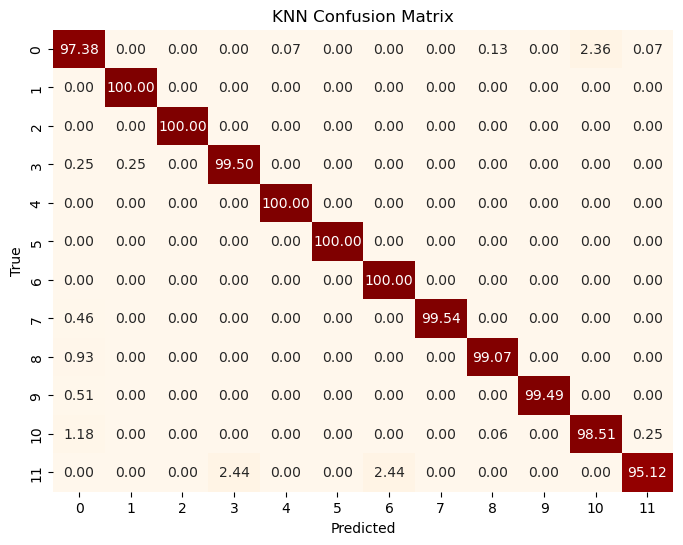

In [118]:
# Evaluate the model
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Accuracy: {accuracy_2}")
print(classification_report(y_test, y_pred_2))

# Compute the confusion matrix
conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_2)

# Convert confusion matrix to percentages
cm_percent_KNN_2 = conf_matrix_knn_2 / np.sum(conf_matrix_knn_2, axis=1, keepdims=True) * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_KNN_2, annot=True, cmap='OrRd', fmt=".2f", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

In [121]:
X, y = X_pca, y

split_1 = [(0.7, 0.3)]
results = []

for train_size, test_size in split_1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = KNeighborsClassifier(n_neighbors=5, weights='distance')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
print("n=5 KNN Best Parameter Classifier Summary")
print('-' * 40)
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)


split_2 = [(0.8, 0.2)]
results = []

for train_size, test_size in split_2:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    model = KNeighborsClassifier(n_neighbors=3, weights='distance')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'train_test_split': f'{int(train_size*100)}/{int(test_size*100)}',
        'accuracy': accuracy,
        'precision_macro_avg': report['macro avg']['precision'],
        'recall_macro_avg': report['macro avg']['recall'],
        'f1_macro_avg': report['macro avg']['f1-score'],
        'precision_weighted_avg': report['weighted avg']['precision'],
        'recall_weighted_avg': report['weighted avg']['recall'],
        'f1_weighted_avg': report['weighted avg']['f1-score']
    })

# Display results
print("n=3 KNN Best Parameter Classifier Summary")
print('-' * 40)
for result in results:
    print(f"Train/Test Split: {result['train_test_split']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision (Macro Avg): {result['precision_macro_avg']:.4f}")
    print(f"Recall (Macro Avg): {result['recall_macro_avg']:.4f}")
    print(f"F1-Score (Macro Avg): {result['f1_macro_avg']:.4f}")
    print(f"Precision (Weighted Avg): {result['precision_weighted_avg']:.4f}")
    print(f"Recall (Weighted Avg): {result['recall_weighted_avg']:.4f}")
    print(f"F1-Score (Weighted Avg): {result['f1_weighted_avg']:.4f}")
    print('-' * 40)
    

n=5 KNN Best Parameter Classifier Summary
----------------------------------------
Train/Test Split: 70/30
Accuracy: 0.9879
Precision (Macro Avg): 0.9739
Recall (Macro Avg): 0.9819
F1-Score (Macro Avg): 0.9774
Precision (Weighted Avg): 0.9879
Recall (Weighted Avg): 0.9879
F1-Score (Weighted Avg): 0.9879
----------------------------------------
n=3 KNN Best Parameter Classifier Summary
----------------------------------------
Train/Test Split: 80/20
Accuracy: 0.9893
Precision (Macro Avg): 0.9682
Recall (Macro Avg): 0.9905
F1-Score (Macro Avg): 0.9783
Precision (Weighted Avg): 0.9894
Recall (Weighted Avg): 0.9893
F1-Score (Weighted Avg): 0.9894
----------------------------------------


We observe that all metrics except macro averaged precision improved in the 80/20 split compared to the 70/30 split. The macro average for precision decreased by ~0.02 in the 80/20 split, sugesting that the classifier performed slightly worse in identifying all the classes with a smaller training set. The macro averaged recall and F1-score improved in the 80/20 split, perhaps indicating that the classifier became better at identifying relevant instances for all classes. All three weighted metrics improved in favor of the 80/20 split. 

### SVM

Here we apply the SVM classifier, chosen for its effectiveness in handling high-dimensional spaces. It is a powerful binary classifier that attempts to find the optimal boundary, or hyperplane, between different classes. Their capability to use kernel functions makes them a viable option for non-linear classification. Here,we performed a random search for the best parameters and assume applicability to both the 70/30 and 80/20 splits. In this case, we employed an RBF kernel with gamma set to 'scale,' and regularization parameter C set to 10.

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Setting up the parameter grid
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': ['scale'],  
    'kernel': ['poly', 'rbf'] 
}

# Create a GridSearchCV object
svm = SVC()
random_search = RandomizedSearchCV(svm, param_grid, n_iter=10, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

C:\Users\maldo\anaconda3.2\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best cross-validation score: 0.93


The first randomized search compared the RBF and poly kernels, and determined RBF was optimal. For robustness, we repeat the process, this time comparing the linear and RBF.

In [14]:
# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.30, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a smaller subset of the training data for hyperparameter tuning
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Setting up the parameter grid
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': ['scale'],  
    'kernel': ['linear', 'rbf'] 
}

# Create a RandomizedSearchCV object
svm = SVC()
random_search = RandomizedSearchCV(svm, param_grid, n_iter=5, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train_subset, y_train_subset)

# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best cross-validation score: 0.93


Since RBF remains the best parameter for the kernel, we proceed with the following implementations using RBF as our kernel.

Accuracy: 0.9795806745670009
                            precision    recall  f1-score   support

            ARP_poisioning       0.95      0.97      0.96      2303
            DDOS_Slowloris       0.99      0.84      0.91       164
             DOS_SYN_Hping       1.00      1.00      1.00      2479
              MQTT_Publish       1.00      1.00      1.00      1229
Metasploit_Brute_Force_SSH       1.00      0.83      0.91         6
             NMAP_FIN_SCAN       0.89      1.00      0.94         8
         NMAP_OS_DETECTION       1.00      1.00      1.00       607
             NMAP_TCP_scan       0.99      0.99      0.99       319
             NMAP_UDP_SCAN       0.97      0.98      0.98       766
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       616
               Thing_Speak       0.97      0.96      0.97      2405
                Wipro_bulb       0.96      0.76      0.85        68

                  accuracy                           0.98     10970
                 

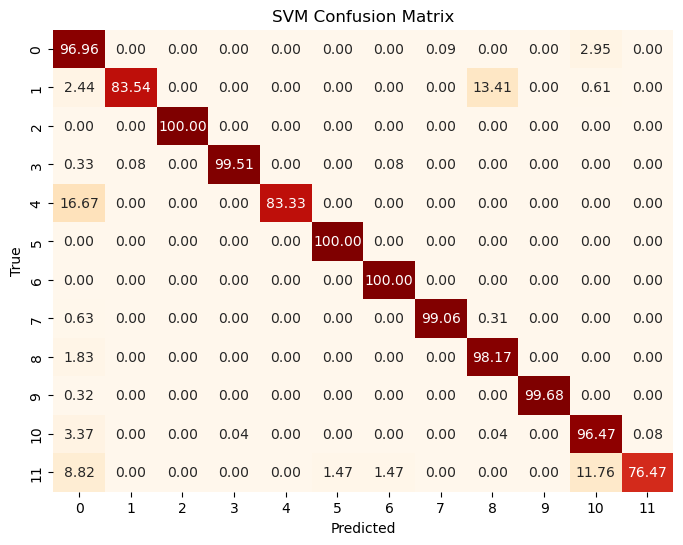

In [15]:
# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.30, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Implementing the SVM model with the optimal parameters
optimal_params = {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
svm_model = SVC(kernel=optimal_params['kernel'], gamma=optimal_params['gamma'], C=optimal_params['C'])

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to percentages
cm_percent_svm = conf_matrix_svm / np.sum(conf_matrix_svm, axis=1, keepdims=True) * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_svm, annot=True, cmap='OrRd', fmt=".2f", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

Accuracy: 0.9805851791085589
                            precision    recall  f1-score   support

            ARP_poisioning       0.95      0.97      0.96      1526
            DDOS_Slowloris       0.99      0.84      0.91       113
             DOS_SYN_Hping       1.00      1.00      1.00      1657
              MQTT_Publish       1.00      0.99      1.00       807
Metasploit_Brute_Force_SSH       1.00      0.75      0.86         4
             NMAP_FIN_SCAN       0.80      1.00      0.89         4
         NMAP_OS_DETECTION       1.00      1.00      1.00       401
             NMAP_TCP_scan       0.99      1.00      0.99       219
             NMAP_UDP_SCAN       0.97      0.99      0.98       536
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       393
               Thing_Speak       0.97      0.97      0.97      1613
                Wipro_bulb       0.97      0.78      0.86        41

                  accuracy                           0.98      7314
                 

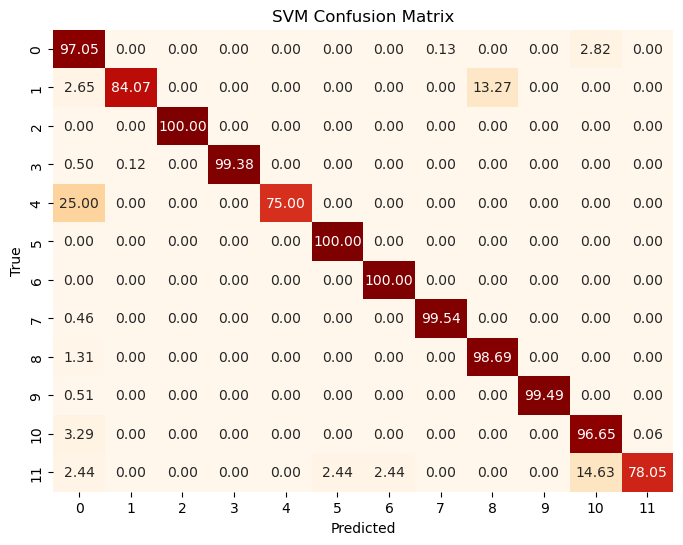

In [16]:
# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Implementing the SVM model with the optimal parameters
optimal_params = {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
svm_model = SVC(kernel=optimal_params['kernel'], gamma=optimal_params['gamma'], C=optimal_params['C'])

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to percentages
cm_percent_svm = conf_matrix_svm / np.sum(conf_matrix_svm, axis=1, keepdims=True) * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_svm, annot=True, cmap='OrRd', fmt=".2f", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

# Conclusion:

The results obtained from implementing different machine learning algorithms indicate differences in performance based on the test vs. training split, and highlight certain trade-offs between overall accuracy and performance metrics specific to each class. While Random Forest marginally outperforms Decision Tree in both 70/30 and 80/20 train/test splits, the differences are not substantial. The Decision Tree model remains a competitive and computationally efficient alternative for simpler classification tasks. However, Random Forest's ensemble approach provides better generalization and robustness, making it suitable for high-stakes classification tasks.

- **Forward vs. Backward Significance**:
  - The significant forward features suggest that activities in the forward direction (typically originating from the client to the server) are critical for cybersecurity analysis.
  - **Forward-Direction Dominance**: Forward-direction features provide more comprehensive insights due to the client-initiated nature of attacks, data exfiltration, and network reconnaissance.
  - However, backward features like inter-arrival times still offer complementary value by revealing response patterns and anomalies in server behavior.


    
